# **What are the top 5 best zip codes for us to invest in?**

# Step 1: Load the Data/Filtering for Chosen Zipcodes


In [231]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA


In [232]:
import pandas as pd
df = pd.read_csv("./zillow_data.csv")
df.head()

RegionID  RegionName      City State              Metro CountyName  \
0     84654       60657   Chicago    IL            Chicago       Cook   
1     90668       75070  McKinney    TX  Dallas-Fort Worth     Collin   
2     91982       77494      Katy    TX            Houston     Harris   
3     84616       60614   Chicago    IL            Chicago       Cook   
4     93144       79936   El Paso    TX            El Paso    El Paso   

   SizeRank   1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  \
0         1  334200.0  335400.0  336500.0  ...  1005500  1007500  1007800   
1         2  235700.0  236900.0  236700.0  ...   308000   310000   312500   
2         3  210400.0  212200.0  212200.0  ...   321000   320600   320200   
3         4  498100.0  500900.0  503100.0  ...  1289800  1287700  1287400   
4         5   77300.0   77300.0   77300.0  ...   119100   119400   120000   

   2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
0  1009600  1013300  1018700  1024400  1030700  1033800  1030600  
1   314100   315000   316600   318100   319600   321100   321800  
2   320400   320800   321200   321200   323000   326900   329900  
3  1291500  1296600  1299000  1302700  1306400  1308500  1307000  
4   120300   120300   120300   120300   120500   121000   121500  

[5 rows x 272 columns]

In [233]:
def get_datetimes(df):
    """
    Takes a dataframe:
    returns only those column names that can be converted into datetime objects 
    as datetime objects.
    NOTE number of returned columns may not match total number of columns in passed dataframe
    """
    
    return pd.to_datetime(df.columns.values[1:], format='%Y-%m')

In [234]:
df = get_datetimes(df)
df

ValueError: time data "RegionName" at position 0 doesn't match format specified

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


In [ ]:
df.isna().sum()

RegionID         0
RegionName       0
City             0
State            0
Metro         1043
              ... 
2017-12          0
2018-01          0
2018-02          0
2018-03          0
2018-04          0
Length: 272, dtype: int64

In [ ]:
df.columns


Index(['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName',
       'SizeRank', '1996-04', '1996-05', '1996-06',
       ...
       '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12',
       '2018-01', '2018-02', '2018-03', '2018-04'],
      dtype='object', length=272)

# Step 4: Reshape from Wide to Long Format

In [ ]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [ ]:
data = melt_data(df)
data.head()



value
time                     
1996-04-01  118299.123063
1996-05-01  118419.044139
1996-06-01  118537.423268
1996-07-01  118653.069278
1996-08-01  118780.254312

In [ ]:
data.isna().sum()

value    0
dtype: int64

# Step 3: EDA and Visualization


In [ ]:
data['value'].plot(figsize=(14, 6))

<AxesSubplot: xlabel='time'>

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.


findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

# Step 5: ARIMA Modeling

In [ ]:
from statsmodels.tsa.stattools import adfuller

def stationarity_check(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])

stationarity_check(data['value'])


ADF Statistic: -1.8851445183777893
p-value: 0.33908154394125534
Critical Values: {'1%': -3.455558114028747, '5%': -2.872635586277424, '10%': -2.572682677000175}


In [ ]:
from pmdarima import auto_arima
model_1 = auto_arima(data['value'], truce=True, suppress_warnings=True)
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  265
Model:               SARIMAX(0, 2, 1)   Log Likelihood               -1857.963
Date:                Mon, 15 Jan 2024   AIC                           3719.926
Time:                        13:54:32   BIC                           3727.071
Sample:                    04-01-1996   HQIC                          3722.798
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0666      0.014     -4.919      0.000      -0.093      -0.040
sigma2      7.702e+04   1565.269     49.203      0.000    7.39e+04    8.01e+04
===================================================================================
Ljung-Box (L1) (Q):                  10.94   Jarque-Bera (JB):             15800.60
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.66   Skew:                            -2.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        40.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
train_percentage = 0.8 
split_index = int(len(data) * train_percentage)
train_data = data.iloc[:split_index]
test_data = data.iloc[split_index:]
print("Train set shape:", train_data.shape)
print("Test set shape:", test_data.shape)

Train set shape: (212, 1)
Test set shape: (53, 1)


In [ ]:
import warnings
warnings.filterwarnings('ignore')

model = ARIMA(train_data['value'], order=(0,2,1))
model = model.fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  212
Model:                 ARIMA(0, 2, 1)   Log Likelihood               -1501.590
Date:                Mon, 15 Jan 2024   AIC                           3007.181
Time:                        14:00:28   BIC                           3013.875
Sample:                    04-01-1996   HQIC                          3009.887
                         - 11-01-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0507      0.016     -3.237      0.001      -0.081      -0.020
sigma2      9.153e+04   2200.330     41.600      0.000    8.72e+04    9.58e+04
===================================================================================
Ljung-Box (L1) (Q):                  10.26   Jarque-Bera (JB):             10033.03
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              31.79   Skew:                            -2.60
Prob(H) (two-sided):                  0.00   Kurtosis:                        36.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot: xlabel='time'>

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

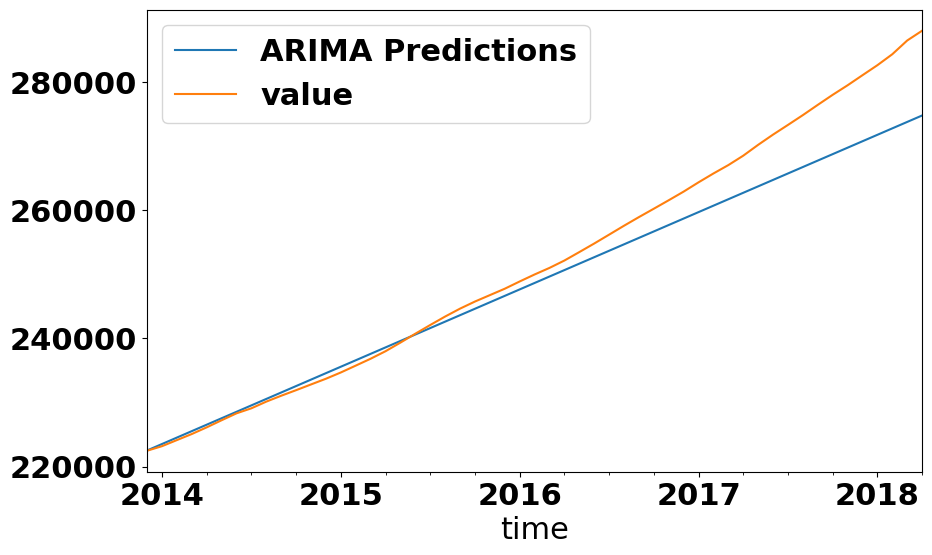

In [ ]:
start=len(train_data)
end=len(train_data)+len(test_data)-1
pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
pred.plot(legend=True, figsize=(10, 6))
test_data['value'].plot(legend=True)

In [ ]:
print(pred)

2013-12-01    222515.480264
2014-01-01    223521.079591
2014-02-01    224526.678919
2014-03-01    225532.278247
2014-04-01    226537.877574
2014-05-01    227543.476902
2014-06-01    228549.076229
2014-07-01    229554.675557
2014-08-01    230560.274885
2014-09-01    231565.874212
2014-10-01    232571.473540
2014-11-01    233577.072867
2014-12-01    234582.672195
2015-01-01    235588.271523
2015-02-01    236593.870850
2015-03-01    237599.470178
2015-04-01    238605.069505
2015-05-01    239610.668833
2015-06-01    240616.268161
2015-07-01    241621.867488
2015-08-01    242627.466816
2015-09-01    243633.066143
2015-10-01    244638.665471
2015-11-01    245644.264799
2015-12-01    246649.864126
2016-01-01    247655.463454
2016-02-01    248661.062782
2016-03-01    249666.662109
2016-04-01    250672.261437
2016-05-01    251677.860764
2016-06-01    252683.460092
2016-07-01    253689.059420
2016-08-01    254694.658747
2016-09-01    255700.258075
2016-10-01    256705.857402
2016-11-01    257711

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
test_data['value'].mean()
range_value = data['value'].max() - data['value'].min()

rmse=sqrt(mean_squared_error(pred,test_data['value']))
print((rmse/range_value) * 100)

2.9979663235710707
